<a href="https://colab.research.google.com/github/nickzherdev/DroneLight/blob/master/DroneLight_works.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Overview:

STEPS
- collecting training and testing data 
- extracting features from IMU inputs 
- for each input gesture classifier needs to recognize the correct label
- draw visualization
- using this label as a key in dictionary we can send numpy array value to drone

### Questions

1) Get data
    - how to store it?
    - How to assign raw data samples with labels?
    - what are the features?
        - raw sensor inputs?
        - filtered with Kalman Filter?
    - what is the target?
    - target label (a letter) corresponds with numpy array of setpoints for drone 

![image.png](attachment:image.png)

###  IMU Data Reading

In  our  project,  the  user wears the glove and performs one of four gesture patterns. We  use  the  Arduino Nano, IMU sensor MPU-6050 and flex sensor,  shown  in  Figure 2 , as our data input source.  

When flex sensor bends more than some threshold - data recording starts, when flex sensor is relaxed - data recording stops. To prevent drift of IMU readings we perform automatic reset before each new recording.

IMU provides us with 6 degree of freedom sensor readings
    - gyroscopes
    - accelerometers 
Inputs  from  IMU  are  streaming  to  local  PC through Arduino which is connected by USB

In order for the dataset to be more variative, non-uniform and robust to noise gestures we recorded data:
    - clock-wise
    - counterclock-wise
    - at different pitch-roll angle
    - upside-down
    - using 5 different hands for larger range of motions
    - moving with different speed

### Training Data Collection

For each of the letters [S, k, o, l] we collect 100 [?] sets of data samples manually. Each data sample is a sequence of 
    - raw IMU sensor readings? (6 features)
    - Kalman-filtered? (3 features)
that has a pre-defined start and ending time. We also include a label describing the gesture pattern for each data sample. 

For the first iteration of the project, the proposed algorithm should map 4 input gestures to 4 letters, which correspond to 4 sets of flight setpoints.

### Data Pre-Processing and Feature Extraction

To classify a specific gesture pattern accurately, we need to take into account of both the pose and the position of glove.

- we normalize the gyroscope and accelerometer inputs
- we process all our input sequences to be the same length by sampling within the start-end window
- we create a synthetic data with transform operators and inversing order of the original recordings (for [x, y, z])
-  each of our input data sample is a sequence of ___ dimensional feature arrays representing the status of the glove at a specific time step

### Training classifier

- use dimension reduction?
- 

### Arduino Software

- module responsible for writing data 

### The Drone part

these setpoints need to be sent to drone to follow this path

with numpy (x, y z) array make a drone to fly through these setponts (Roman)

control LED while flying

record the drone flight

Input: recorded gestures / path from glove with IMU

Output: drone light-painting the letter / word


### Improvements

- Recognize fake gestures?

# Let's begin

#### Import libs

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import seaborn as sns
from scipy import signal

sns.set()
%matplotlib inline

# ignore FutureWarning from sklearn
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# display pandas results to 3 decimal points, not in scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#### Read an example of the data

['/content/s2.csv', '/content/s1.csv']


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

# ! ls /content



In [0]:
data = pd.read_csv('s1.csv')
data.columns = ['Acc_x', 'Acc_y', 'Acc_z']
data.head()

,Acc_x,Acc_y,Acc_z
0,-5396,-628,14028
1,-4912,-24,14032
2,-5196,572,15120
3,-6132,2052,15384
4,-7356,2352,14880


In [0]:
data.shape

(72, 3)

#### Draw raw data

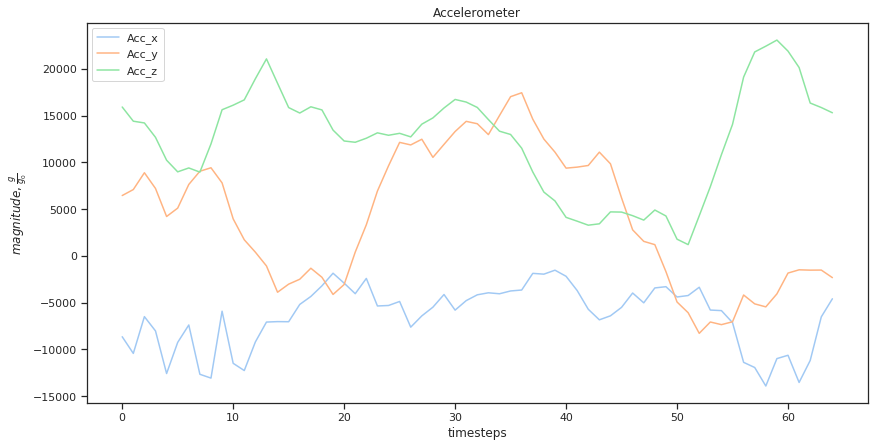

In [0]:
sns.set(style="ticks", palette="pastel", rc={'figure.figsize':(14,7)})

for column in data.columns:
  plt.plot(data[column])
  
plt.legend(loc='best')
plt.ylabel(r'$magnitude, \frac{g}{g_0}$')
plt.xlabel('timesteps')
plt.title('Accelerometer')
plt.show()

#### Draw smoothed data

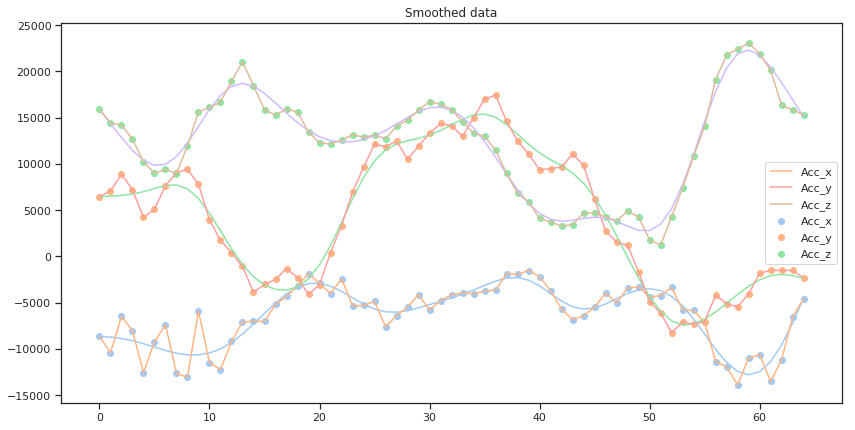

In [0]:
for i, val in enumerate(data.columns):
  plt.plot(signal.filtfilt(*signal.butter(3, 0.2), data.iloc[:, i]))
  plt.plot(data.iloc[:, i])
  plt.scatter(range(len(data.iloc[:, i])), data.iloc[:, i])

plt.title("Smoothed data")
plt.legend(loc='best');

#### Filter data and make each sequence the same length

Filter the accellerometers signal using a low pass filter. This removes any noise that is not caused by slow moving arm.

In [0]:
def discretize_data(data, samples):
    # width = round(len(data) / samples)
    width = int(len(data) / samples)

    # print('width =', width)
    output = [np.mean(data[i*width : (i+1)*width]) for i in range(samples)]
    return output

def smooth_data(X, a, b):
  return signal.filtfilt(*signal.butter(a, b), X)

#### Draw equalized filtered data

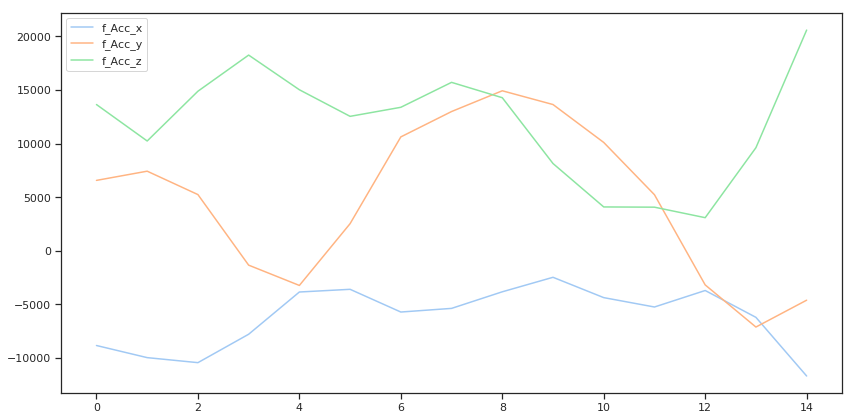

In [0]:
for i, val in enumerate(data.columns):
  plt.plot(df.iloc[:, i])

plt.legend(loc='best');

#### Create array of features (for each gesture we have separate csv file)

In [5]:
import glob
import pandas as pd

files = glob.glob('/content/drive/My Drive/Colab/data_set_o/*.csv')
# print(files)

dataset = pd.DataFrame()

for i, val in enumerate(files):
    data = pd.read_csv(val)
    # print(data.shape)
    data.columns = ['Acc_x', 'Acc_y', 'Acc_z']
    # print(i, val[39])
    letter = pd.Series(val[41], index=['letter'])

    # data.drop(data.tail(60).index, inplace=True) # drop last n rows

    df = pd.DataFrame()
    for column in data.columns:
        smooth = smooth_data(data[column], 3, 0.2)
        discrete = discretize_data(smooth, 60)
        df[column] = discrete

    gesture = pd.concat([df["Acc_x"], df["Acc_y"], df["Acc_z"]], ignore_index=True)
    # gesture = pd.concat([data["Acc_x"], data["Acc_y"], data["Acc_z"]], ignore_index=True)

    gesture = pd.concat([letter, gesture])
    dataset = dataset.append(gesture, ignore_index=True)

# dataset = dataset.transpose()
# dataset.set_index('letter', inplace=True)

dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,letter
0,-4712.956,-3922.361,-3284.463,-2926.307,-2922.512,-3280.013,-3946.297,-4845.511,-5910.837,-7077.013,-8246.205,-9276.046,-10010.541,-10327.197,-10169.140,-9555.456,-8575.694,-7374.968,-6129.765,-5007.371,-4117.232,-3484.713,-3065.140,-2785.156,-2587.579,-2459.697,-2432.654,-2555.981,-2865.421,-3357.031,-3970.225,-4587.294,-5059.304,-5252.998,-5098.864,-4618.808,-3921.076,-3167.487,-2530.115,-2151.861,...,15806.242,13749.767,11748.564,10269.863,9679.955,10172.500,11755.638,14276.155,17447.936,20874.861,24087.153,26614.548,28090.285,28341.894,27420.846,25558.716,23077.094,20294.589,17464.115,14748.567,12224.086,9899.274,7744.279,5722.254,3813.665,2028.172,403.141,-1008.689,-2150.695,-2955.691,-3320.117,-3085.526,-2056.264,-55.855,2996.238,7005.158,11638.042,16318.133,20321.839,s
1,-8212.806,-8097.251,-7950.739,-7709.253,-7301.971,-6703.684,-5977.267,-5303.444,-4970.352,-5277.689,-6376.701,-8147.555,-10197.571,-11972.495,-12921.976,-12664.283,-11103.685,-8466.908,-5247.771,-2070.061,490.903,2059.144,2525.509,2022.622,837.664,-690.446,-2251.369,-3607.491,-4607.448,-5181.511,-5332.431,-5131.301,-4717.107,-4284.044,-4037.855,-4126.745,-4588.807,-5360.253,-6337.328,-7433.444,...,14202.857,9966.887,6437.628,3729.267,1776.908,402.344,-593.671,-1351.617,-1923.924,-2306.344,-2500.854,-2559.660,-2571.485,-2587.698,-2526.315,-2115.726,-936.332,1421.119,5136.081,9995.531,15387.599,20458.997,24362.883,26501.340,26677.374,25103.127,22278.833,18823.509,15337.396,12319.335,10121.266,8924.713,8739.738,9430.305,10764.972,12482.479,14344.590,16144.706,17680.359,k
2,-2474.874,-3930.929,-5189.575,-6115.706,-6661.596,-6873.856,-6893.683,-6929.201,-7171.533,-7685.753,-8356.552,-8938.839,-9184.737,-8957.855,-8263.088,-7202.603,-5916.876,-4548.376,-3235.792,-2126.451,-1372.755,-1091.213,-1310.475,-1952.708,-2860.000,-3842.626,-4724.473,-5377.648,-5744.040,-5834.402,-5699.902,-5396.094,-4969.823,-4472.681,-3974.714,-3552.512,-3248.583,-3031.246,-2800.876,-2451.505,...,13278.243,11611.365,10289.658,9204.880,8156.617,6923.276,5356.102,3449.354,1344.244,-731.013,-2539.320,-3884.611,-4622.441,-4657.845,-3964.770,-2625.469,-843.964,1106.487,2989.088,4710.296,6373.678,8244.434,10625.394,13695.399,17384.659,21339.802,24991.309,27706.256,28986.380,28645.041,26885.919,24239.062,21376.165,18888.552,17129.088,16172.503,15876.126,15986.748,16242.324,O
3,-6142.225,-6646.381,-7002.834,-7160.023,-7185.571,-7217.116,-7381.216,-7731.557,-8232.761,-8784.897,-9265.309,-9568.316,-9635.206,-9468.904,-9129.412,-8707.240,-8276.249,-7853.775,-7400.716,-6850.672,-6139.801,-5235.480,-4164.899,-3027.566,-1982.499,-1215.291,-889.436,-1089.771,-1779.369,-2793.507,-3883.676,-4804.947,-5406.993,-5674.761,-5702.532,-5631.338,-5583.463,-5614.156,-5697.740,-5753.883,...,19148.825,18361.695,17378.017,16303.387,15186.731,14004.281,12678.386,11115.558,9250.417,7084.562,4704.276,2267.215,-32.394,-2002.342,-3485.243,-4383.525,-4674.764,-4412.368,-3707.849,-2699.557,-1520.802,-280.340,940.781,2085.306,3123.702,4069.795,4992.744,6004.980,7225.430,8739.097,10570.772,12673.508,14929.346,17163.639,19168.360,20731.676,21680.126,21924.398,21484.394,O
4,-862.439,-2426.047,-3651.333,-4362.161,-4594.833,-4543.702,-4460.781,-4555.398,-4916.912,-5489.399,-6109.499,-6581.182,-6748.767,-6541.485,-5983.268,-5177.053,-4271.348,-3413.676,-2707.536,-2196.414,-1880.514,-1747.979,-1796.774,-2034.852,-2461.238,-3041.877,-3697.981,-4316.695,-4778.585,-4990.545,-4916.959,-4598.199,-4141.540,-3686.151,-3362.545,-3262.442,-3422.837,-3826.378,-4418.389,-5132.691,...,13862.757,11898.441,10686.956,10530.427,11518.643,13512.409,16174.904,19040.670,21611.909,23463.244,24328.451,24144.840,23040.865,21271.066,19126.091,16858.981,14658.052,12661.863,1

In [6]:
y = dataset.iloc[:, -1]
y.head()

0    s
1    k
2    O
3    O
4    s
Name: letter, dtype: object

In [7]:
X = dataset.iloc[:, 0:-1]
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
0,-4712.956,-3922.361,-3284.463,-2926.307,-2922.512,-3280.013,-3946.297,-4845.511,-5910.837,-7077.013,-8246.205,-9276.046,-10010.541,-10327.197,-10169.140,-9555.456,-8575.694,-7374.968,-6129.765,-5007.371,-4117.232,-3484.713,-3065.140,-2785.156,-2587.579,-2459.697,-2432.654,-2555.981,-2865.421,-3357.031,-3970.225,-4587.294,-5059.304,-5252.998,-5098.864,-4618.808,-3921.076,-3167.487,-2530.115,-2151.861,...,17465.978,15806.242,13749.767,11748.564,10269.863,9679.955,10172.500,11755.638,14276.155,17447.936,20874.861,24087.153,26614.548,28090.285,28341.894,27420.846,25558.716,23077.094,20294.589,17464.115,14748.567,12224.086,9899.274,7744.279,5722.254,3813.665,2028.172,403.141,-1008.689,-2150.695,-2955.691,-3320.117,-3085.526,-2056.264,-55.855,2996.238,7005.158,11638.042,16318.133,20321.839
1,-8212.806,-8097.251,-7950.739,-7709.253,-7301.971,-6703.684,-5977.267,-5303.444,-4970.352,-5277.689,-6376.701,-8147.555,-10197.571,-11972.495,-12921.976,-12664.283,-11103.685,-8466.908,-5247.771,-2070.061,490.903,2059.144,2525.509,2022.622,837.664,-690.446,-2251.369,-3607.491,-4607.448,-5181.511,-5332.431,-5131.301,-4717.107,-4284.044,-4037.855,-4126.745,-4588.807,-5360.253,-6337.328,-7433.444,...,18834.121,14202.857,9966.887,6437.628,3729.267,1776.908,402.344,-593.671,-1351.617,-1923.924,-2306.344,-2500.854,-2559.660,-2571.485,-2587.698,-2526.315,-2115.726,-936.332,1421.119,5136.081,9995.531,15387.599,20458.997,24362.883,26501.340,26677.374,25103.127,22278.833,18823.509,15337.396,12319.335,10121.266,8924.713,8739.738,9430.305,10764.972,12482.479,14344.590,16144.706,17680.359
2,-2474.874,-3930.929,-5189.575,-6115.706,-6661.596,-6873.856,-6893.683,-6929.201,-7171.533,-7685.753,-8356.552,-8938.839,-9184.737,-8957.855,-8263.088,-7202.603,-5916.876,-4548.376,-3235.792,-2126.451,-1372.755,-1091.213,-1310.475,-1952.708,-2860.000,-3842.626,-4724.473,-5377.648,-5744.040,-5834.402,-5699.902,-5396.094,-4969.823,-4472.681,-3974.714,-3552.512,-3248.583,-3031.246,-2800.876,-2451.505,...,15279.496,13278.243,11611.365,10289.658,9204.880,8156.617,6923.276,5356.102,3449.354,1344.244,-731.013,-2539.320,-3884.611,-4622.441,-4657.845,-3964.770,-2625.469,-843.964,1106.487,2989.088,4710.296,6373.678,8244.434,10625.394,13695.399,17384.659,21339.802,24991.309,27706.256,28986.380,28645.041,26885.919,24239.062,21376.165,18888.552,17129.088,16172.503,15876.126,15986.748,16242.324
3,-6142.225,-6646.381,-7002.834,-7160.023,-7185.571,-7217.116,-7381.216,-7731.557,-8232.761,-8784.897,-9265.309,-9568.316,-9635.206,-9468.904,-9129.412,-8707.240,-8276.249,-7853.775,-7400.716,-6850.672,-6139.801,-5235.480,-4164.899,-3027.566,-1982.499,-1215.291,-889.436,-1089.771,-1779.369,-2793.507,-3883.676,-4804.947,-5406.993,-5674.761,-5702.532,-5631.338,-5583.463,-5614.156,-5697.740,-5753.883,...,19626.428,19148.825,18361.695,17378.017,16303.387,15186.731,14004.281,12678.386,11115.558,9250.417,7084.562,4704.276,2267.215,-32.394,-2002.342,-3485.243,-4383.525,-4674.764,-4412.368,-3707.849,-2699.557,-1520.802,-280.340,940.781,2085.306,3123.702,4069.795,4992.744,6004.980,7225.430,8739.097,10570.772,12673.508,14929.346,17163.639,19168.360,20731.676,21680.126,21924.398,21484.394
4,-862.439,-2426.047,-3651.333,-4362.161,-4594.833,-4543.702,-4460.781,-4555.398,-4916.912,-5489.399,-6109.499,-6581.182,-6748.767,-6541.485,-5983.268,-5177.053,-4271.348,-3413.676,-2707.536,-2196.414,-1880.514,-1747.979,-1796.774,-2034.852,-2461.238,-3041.877,-3697.981,-4316.695,-4778.585,-4990.545,-4916.959,-4598.199,-4141.540,-3686.151,-3362.545,-3262.442,-3422.837,-3826.378,-4418.389,-5132.691,...,16135.819,13862.757,11898.441,10686.956,10530.427,11518.643,13512.409,16174.904,19040.670,21611.909,23463.244,24328.451,24144.840,23040.865,21271.066,19

#### Get train, validating and testing sets

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=21)

In [0]:
array(['O', 's', 'O', 's', 'O', 's', 'k', 'k', 'k', 's', 's', 'O', 'O',
       's', 'k', 'k', 'k', 'k', 's', 'O', 'O', 'O', 'k', 'O', 'k', 's',
       'O', 'O', 'k', 'k', 'O', 's', 'k', 's', 's', 's', 'k', 'O'],
      dtype=object)

In [12]:
y_test

3     O
19    s
14    O
43    s
10    O
32    s
23    k
57    k
24    k
13    s
22    s
45    O
17    O
29    s
69    k
46    k
11    k
40    k
8     s
1     k
7     O
2     O
21    k
42    O
36    k
39    s
47    O
25    O
64    k
31    k
30    O
52    s
72    k
51    s
49    s
0     s
53    k
9     O
Name: letter, dtype: object

#### Check ranges of the data

In [0]:
# X.max(0) - X.min(0)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#### Choose metrics

In [0]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score


def evaluate_model(model, X, y, x_test, cv, scoring='accuracy'):
    """
    Reports perfomance of the model on given set of data (test / train)

    model - sklearn regression model (trained)

    X  - array,
     (n_observations_train, n_features) matrix,
     train data.
     
    y - array,
     (n_observation_train, ) array of train target

    """

    y_pred = model.predict(X_test)
    scores = cross_val_score(model, X, y, scoring=scoring, cv=cv)
    y_pred_cv = cross_val_predict(model, X, y, cv=cv)
    print('KFold cross_val_score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()) )
    
    with np.printoptions(precision=3, suppress=True):
        print('Accuracy of prediction on test set is {}'.format(accuracy_score(y_test, y_pred)))
        print('Precision of prediction on test set is {}'.format(precision_score(y_test, y_pred)))
        print('Recall of prediction on test set is {}'.format(recall_score(y_test, y_pred)))

    # # move to evaluate model!
    # print(model.best_score_)
    # print('roc auc', roc_auc_score(y_test, y_predict_proba))
    # print(model.best_params_)

    return y_pred_cv

#### Write a function for pretty confusion matrix

In [0]:
# from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import train_test_split
# import itertools
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# # clf = SVC(kernel='rbf', class_weight={0:1, 1:1, 2:1})
# clf = RandomForestClassifier(n_estimators = 100)
# y_pred = clf.fit(X_train, y_train).predict(X_test)
# cnf_matrix = confusion_matrix(y_test, y_pred)

# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)
#     plt.figure(figsize=(6, 6), dpi=200)
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
    
# plot_confusion_matrix(cnf_matrix, classes=[cl["cl_name"] for cl in classes],
#                       title='Normalized confusion matrix')

#### Scale data

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train.astype(np.float))
X_test_scaled = scaler.transform(X_test.astype(np.float))

# with np.printoptions(precision=3, suppress=True):
#     print(X_train_scaled)

# with np.printoptions(precision=3, suppress=True):
#     print(scaler.transform(X_test_scaled))

In [15]:
X_test_scaled.shape

(38, 180)

#### Split data using StratifiedKFold

In [0]:
from sklearn.model_selection import StratifiedKFold

stratifiedKFold = StratifiedKFold(n_splits=5, shuffle=True)
cv = stratifiedKFold.split(X_train_scaled, y_train)

#### Try Nearest-Neighbor Classifier (don't forget to normalize data)

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

gs_knn = GridSearchCV(knn, param_grid={"n_neighbors":list(range(1, 20))}, cv=cv)
gs_knn.fit(X_train_scaled, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f7598727d58>,
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [18]:
print(gs_knn.best_score_)
# print('roc auc', roc_auc_score(y_test, y_predict_proba))
print(gs_knn.best_params_)

1.0
{'n_neighbors': 6}


#### RESULTS: Nearest-Neighbor Classifier

In [19]:
y_pred = gs_knn.predict(X_test_scaled)
# scores = cross_val_score(lr, X_train_scaled, y_train, scoring="accuracy", cv=cv)
# y_pred_cv = cross_val_predict(lr, X_test_scaled, y_test, cv=cv)
# print('KFold cross_val_score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()) )

with np.printoptions(precision=3, suppress=True):
    print('Accuracy of prediction on test set is {}'.format(accuracy_score(y_test, y_pred)))
    print('Precision of prediction on test set is {}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Recall of prediction on test set is {}'.format(recall_score(y_test, y_pred, average='weighted')))


# # move to evaluate model!
# print(model.best_score_)
# print('roc auc', roc_auc_score(y_test, y_predict_proba))
# print(model.best_params_)

Accuracy of prediction on test set is 0.9736842105263158
Precision of prediction on test set is 0.9757085020242916
Recall of prediction on test set is 0.9736842105263158


In [20]:
y_pred

array(['O', 's', 'O', 's', 'O', 's', 'k', 'k', 'k', 's', 's', 'O', 'O',
       's', 'k', 'k', 'k', 'k', 's', 'O', 'O', 'O', 'k', 'O', 'k', 's',
       'O', 'O', 'k', 'k', 'O', 's', 'k', 's', 's', 's', 'k', 'O'],
      dtype=object)

In [0]:
# y_pred_cv = evaluate_model(gs_knn, X_train_scaled, y, X_test_scaled, cv)

# params = [x['n_neighbors'] for x in gs_knn.cv_results_['params']]
# fig, ax = plt.subplots(1, 1, figsize=(6, 3))
# plt.plot(params, gs_knn.cv_results_['mean_test_score'])

#### Try Logistic Regression

In [15]:
# from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV

lr = LogisticRegressionCV()  # solver='lbfgs'
lr.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

#### RESULTS: Logistic Regression 

In [22]:
y_pred = lr.predict(X_test_scaled)
# scores = cross_val_score(lr, X_train_scaled, y_train, scoring="accuracy", cv=cv)
# y_pred_cv = cross_val_predict(lr, X_test_scaled, y_test, cv=cv)
# print('KFold cross_val_score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()) )

with np.printoptions(precision=3, suppress=True):
    print('Accuracy of prediction on test set is {}'.format(accuracy_score(y_test, y_pred)))
    # print('Precision of prediction on test set is {}'.format(precision_score(y_test, y_pred)))
    # print('Recall of prediction on test set is {}'.format(recall_score(y_test, y_pred)))


# # move to evaluate model!
# print(model.best_score_)
# print('roc auc', roc_auc_score(y_test, y_predict_proba))
# print(model.best_params_)

Accuracy of prediction on test set is 1.0


ValueError: ignored

In [20]:
y_test

4     s
63    k
10    O
0     s
35    s
61    k
28    k
12    O
69    k
64    k
34    O
42    O
49    s
18    s
9     O
22    s
5     O
33    s
56    s
Name: letter, dtype: object

In [21]:
y_pred

array(['s', 'k', 'O', 's', 's', 'k', 'k', 'O', 'k', 'k', 'O', 'O', 's',
       's', 'O', 's', 'O', 's', 's'], dtype=object)

In [0]:
# y_pred_cv = evaluate_model(lr, X_train_scaled, y, X_test_scaled, cv)

#### Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import Normalizer

gs_rfc = GridSearchCV(RandomForestClassifier(), 
                   {'n_estimators':[50, 100, 200, 300, 400, 500, 750], 
                    'max_depth':[2, 3, 4, 6, 10, 15]
                   },
                   scoring='accuracy', cv=3)
gs_rfc.fit(X_train_scaled, y_train)

#### RESULTS: Random forest

In [0]:
y_pred_cv = evaluate_model(gs_rfc, X_train_scaled, y, X_test_scaled, cv)
y_predict_proba = gs_rfc.predict_proba(X_test_scaled)[:,1]

# params = [x['n_estimators'] for x in gs.cv_results_['params']]
# fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=600)
# plt.plot(params, gs.cv_results_['mean_test_score']);
# ax.set_xlabel('n_estimators')
# ax.set_ylabel('KFold score')
# plt.savefig('img/forest_results.png',bbox_inches='tight');
# plt.close(fig);

In [0]:
# from scipy.fftpack import dct, idct

# N = 100
# t = np.linspace(0,20,N)
# x = np.exp(-t/3)*np.cos(2*t)
# y = dct(x, norm='ortho')
# window = np.zeros(N)
# window[:20] = 1
# yr = idct(y*window, norm='ortho')
# # sum(abs(x-yr)**2) / sum(abs(x)**2)

# plt.plot(t, x, '-bx')
# # plt.plot(t, yr, 'ro')
# window = np.zeros(N)
# window[:15] = 1
# yr = idct(y*window, norm='ortho')
# plt.plot(t, yr, 'g+')

# # sum(abs(x-yr)**2) / sum(abs(x)**2)

# plt.legend(['x', '$x_{20}$', '$x_{15}$'])
# plt.grid()
# plt.show()

In [0]:
    # print('Accuracy of prediction is {}'.format(accuracy_score(y_test, y_pred)))
    # print('Accuracy of prediction on train set is {}'.format(precision_score(y_test, y_pred)))
    # print('Accuracy of prediction on test set is {}'.format(recall_score(y_test, y_pred)))
    


    # print('Accuracy', accuracy_score(y_train, clf.predict(X_train)))
    # print('Precision', precision_score(y_train, clf.predict(X_train)))
    # print('Recall', recall_score(y_train, clf.predict(X_train)))
    

    
    # print(classification_report(y, y_pred))

In [0]:
# files = glob.glob('/content/drive/My Drive/Colab/data_set/*.csv')
# # print(files)
# print(files[20][39])

# frames = [ process_your_file(f) for f in files ]
# result = pd.concat(frames, axis=1, sort=False)

# id = pd.Series('S', index=['id'])
# gesture = pd.concat([df["f_Acc_x"], df["f_Acc_y"], df["f_Acc_z"]], ignore_index=True)
# gesture = pd.concat([id, gesture])

# result = pd.concat([gesture, gesture], axis=1, sort=False)
# dataset = result.transpose()
# # dataset.set_index('id', inplace=True)
# y = dataset['id']
# X = dataset.iloc[:, 1:]
# dataset.head()


## Resources

[1] Real-time Gesture Pattern Classification with IMU Data. 
Alex Fu, Yangyang Yu
http://stanford.edu/class/ee267/Spring2017/report_fu_yu.pdf

- lib for training with IMU

- Attitude Estimation - Data and Code Listings
http://philsal.co.uk/projects/imu-attitude-estimation

https://github.com/pms67/Attitude-Estimation

- Micropython ESP32 board
https://medium.com/@nihal.pasham/micropython-just-works-4e8979e7d7a6

https://github.com/nihalpasham/micropython_sensorfusion

- Smartphone-Based Recognition of Human Activities and Postural Transitions Data Set
https://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions

https://beckernick.github.io/activity-prediction/

- Sensor Fusion on Android Devices: A Revolution in Motion Processing
https://www.youtube.com/watch?v=C7JQ7Rpwn2k

- An introduction to inertial navigation
https://www.cl.cam.ac.uk/techreports/UCAM-CL-TR-696.pdf

- Implementing Positioning Algorithms Using Accelerometers
https://www.nxp.com/docs/en/application-note/AN3397.pdf

- Madgwick
https://x-io.co.uk/open-source-imu-and-ahrs-algorithms/